In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

In [2]:
np.random.seed(11)
tf.random.set_seed(11)
batch_size = 256
max_epochs = 50
learning_rate = 1e-3
momentum = 8e-1
hidden_dim = 128
original_dim = 784

In [3]:
(x_train, _), (x_test, _) = K.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_train = np.reshape(x_train, (x_train.shape[0], 784))
x_test = np.reshape(x_test, (x_test.shape[0], 784))

training_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size)

In [4]:

class SparseEncoder(K.layers.Layer):
    def __init__(self, hidden_dim):
        super(SparseEncoder, self).__init__()
        self.hidden_layer = K.layers.Dense(units=hidden_dim, 
                    activation=tf.nn.relu, activity_regularizer=regularizers.l1(10e-5))
        
    
    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return activation

In [5]:

class SparseDecoder(K.layers.Layer):
    def __init__(self, hidden_dim, original_dim):
        super(SparseDecoder, self).__init__()
        self.output_layer = K.layers.Dense(units=original_dim, activation=tf.nn.relu)
  
    def call(self, encoded):
        activation = self.output_layer(encoded)
        return activation 

In [6]:
class SparseAutoencoder(K.Model):
    def __init__(self, hidden_dim, original_dim):
        super(SparseAutoencoder, self).__init__()
        self.loss = []
        self.encoder = SparseEncoder(hidden_dim=hidden_dim)
        self.decoder = SparseDecoder(hidden_dim=hidden_dim, original_dim=original_dim)

    def call(self, input_features):
        encoded = self.encoder(input_features)
        reconstructed = self.decoder(encoded)
        return reconstructed

In [7]:
autoencoder = SparseAutoencoder(hidden_dim=hidden_dim, original_dim=original_dim)
opt = tf.optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

def loss(preds, real):
    return tf.reduce_mean(tf.square(tf.subtract(preds, real))) 

def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        preds = model(original)
        reconstruction_error = loss(preds, original)
    gradients = tape.gradient(reconstruction_error, model.trainable_variables)
    gradient_variables = zip(gradients, model.trainable_variables)
    opt.apply_gradients(gradient_variables)
  
    return reconstruction_error

In [8]:
def train_loop(model, opt, loss, dataset, epochs=20):
    for epoch in range(epochs):
        epoch_loss = 0
        for step, batch_features in enumerate(dataset):
            loss_values = train(loss, model, opt, batch_features)
            epoch_loss += loss_values
        model.loss.append(epoch_loss)
        print('Epoch {}/{}. Loss: {}'.format(epoch + 1, epochs, epoch_loss.numpy()))

In [9]:
model = SparseAutoencoder(hidden_dim=hidden_dim, original_dim=original_dim)
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)

train_loop(model, opt, loss, training_dataset, epochs=max_epochs)

Epoch 1/50. Loss: 5.1587958335876465
Epoch 2/50. Loss: 3.072758913040161
Epoch 3/50. Loss: 2.9567911624908447
Epoch 4/50. Loss: 2.8891077041625977
Epoch 5/50. Loss: 2.893104314804077
Epoch 6/50. Loss: 2.843897581100464
Epoch 7/50. Loss: 2.843674898147583
Epoch 8/50. Loss: 2.8288328647613525
Epoch 9/50. Loss: 2.807680368423462
Epoch 10/50. Loss: 2.851358413696289
Epoch 11/50. Loss: 2.804849863052368
Epoch 12/50. Loss: 2.7799880504608154
Epoch 13/50. Loss: 2.8308520317077637
Epoch 14/50. Loss: 2.81044340133667
Epoch 15/50. Loss: 2.814807176589966
Epoch 16/50. Loss: 2.8045241832733154
Epoch 17/50. Loss: 2.7953529357910156
Epoch 18/50. Loss: 2.801511526107788
Epoch 19/50. Loss: 2.800142288208008
Epoch 20/50. Loss: 2.812126398086548
Epoch 21/50. Loss: 2.806365966796875
Epoch 22/50. Loss: 2.826596736907959
Epoch 23/50. Loss: 2.8027992248535156
Epoch 24/50. Loss: 2.792048931121826
Epoch 25/50. Loss: 2.807739019393921
Epoch 26/50. Loss: 2.8026280403137207
Epoch 27/50. Loss: 2.8349876403808594


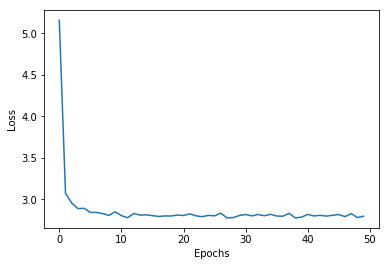

In [10]:

plt.plot(range(max_epochs), model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

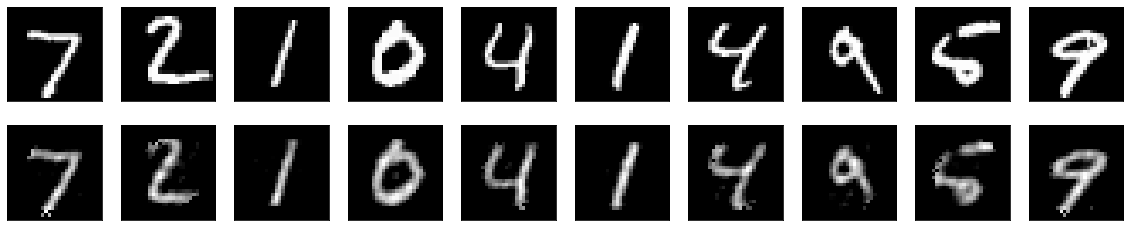

In [11]:
number = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for index in range(number):
    # display original
    ax = plt.subplot(2, number, index + 1)
    plt.imshow(x_test[index].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, number, index + 1 + number)
    plt.imshow(model(x_test)[index].numpy().reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()